In [1]:
import copy
import glob
import json
import os
import random
import re
from collections import Counter
from random import shuffle

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import fastparquet
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
dataset_folder='./../dataset/saved/'

In [2]:
df_train = pd.read_pickle(dataset_folder+'train_2_ohe401')
df_test = pd.read_pickle(dataset_folder+'test_2_ohe401')
df_valid = pd.read_pickle(dataset_folder+'valid_2_ohe401')

In [3]:
df_train_meta, df_train_num = df_train[['correct', 'group']], df_train.drop(columns=['correct', 'group', 'name', 'firstChar'])
df_test_meta, df_test_num = df_test[['correct', 'group']], df_test.drop(columns=['correct', 'group', 'name', 'firstChar'])
df_valid_meta, df_valid_num = df_valid[['correct', 'group']], df_valid.drop(columns=['correct', 'group', 'name', 'firstChar'])

In [4]:
print(df_train_num.dtypes)
print(df_train_num.shape)
print('--------')
print(df_train_meta.dtypes)
print(df_train_meta.shape)

name_Abstract                    Sparse[int64, 0]
name_Action                      Sparse[int64, 0]
name_Actions                     Sparse[int64, 0]
name_All                         Sparse[int64, 0]
name_An                          Sparse[int64, 0]
                                       ...       
insideStatement2_if_then_body    Sparse[int64, 0]
insideStatement2_return          Sparse[int64, 0]
insideStatement2_ternary_else    Sparse[int64, 0]
insideStatement2_try             Sparse[int64, 0]
insideStatement2_while_body      Sparse[int64, 0]
Length: 735, dtype: object
(332180, 735)
--------
correct    int64
group      int64
dtype: object
(332180, 2)


In [5]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)
print('go')
train_intr = poly.fit_transform(df_train_num)
print('1')
test_intr = poly.fit_transform(df_test_num)
print('2')
valid_intr = poly.fit_transform(df_valid_num)
print('3')

go
1
2
3


In [6]:
# train_intr = SelectKBest(score_func=chi2, k=3*10**3).fit_transform(train_intr, df_train_meta['correct'])
# test_intr = SelectKBest(score_func=chi2, k=3*10**3).fit_transform(test_intr, df_test_meta['correct'])
# valid_intr = SelectKBest(score_func=chi2, k=3*10**3).fit_transform(valid_intr, df_valid_meta['correct'])

In [7]:
print(f'train ########## ------> : {train_intr.shape}')
print(f'test ########## ------> : {test_intr.shape}')
print(f'valid ########## ------> : {valid_intr.shape}')

train ########## ------> : (332180, 270480)
test ########## ------> : (193326, 270480)
valid ########## ------> : (134146, 270480)


In [8]:
train_cols = df_train_num.columns.tolist()
train_cols = train_cols + [f'intr_{i}' for i in range(train_intr.shape[1] - len(train_cols))]

test_cols = df_test_num.columns.tolist()
test_cols = test_cols + [f'intr_{i}' for i in range(test_intr.shape[1] - len(test_cols))]

valid_cols = df_valid_num.columns.tolist()
valid_cols = valid_cols + [f'intr_{i}' for i in range(valid_intr.shape[1] - len(valid_cols))]

train_cols

['name_Abstract',
 'name_Action',
 'name_Actions',
 'name_All',
 'name_An',
 'name_Android',
 'name_Application',
 'name_Aware',
 'name_Base',
 'name_Bundle',
 'name_Change',
 'name_Class',
 'name_Code',
 'name_Common',
 'name_Component',
 'name_Configuration',
 'name_Container',
 'name_Content',
 'name_Context',
 'name_Data',
 'name_Debugger',
 'name_Default',
 'name_Descriptor',
 'name_Dialog',
 'name_Diff',
 'name_Directory',
 'name_Document',
 'name_Dumb',
 'name_Editor',
 'name_Element',
 'name_Event',
 'name_Ex',
 'name_External',
 'name_Factory',
 'name_File',
 'name_Git',
 'name_Group',
 'name_Handler',
 'name_Hg',
 'name_Icons',
 'name_Ide',
 'name_Impl',
 'name_Info',
 'name_Inspection',
 'name_JB',
 'name_Java',
 'name_Keys',
 'name_List',
 'name_Log',
 'name_Logger',
 'name_Manager',
 'name_Maven',
 'name_Messages',
 'name_Model',
 'name_Module',
 'name_Node',
 'name_Places',
 'name_Platform',
 'name_Popup',
 'name_Presentation',
 'name_Project',
 'name_Properties',
 'name_

In [9]:
df_train_num_intr = pd.DataFrame.sparse.from_spmatrix(train_intr, columns=train_cols)
df_test_num_intr = pd.DataFrame.sparse.from_spmatrix(test_intr, columns=test_cols)
df_valid_num_intr = pd.DataFrame.sparse.from_spmatrix(valid_intr, columns=valid_cols)

In [10]:
df_train_num_intr.dtypes

name_Abstract    Sparse[float64, 0]
name_Action      Sparse[float64, 0]
name_Actions     Sparse[float64, 0]
name_All         Sparse[float64, 0]
name_An          Sparse[float64, 0]
                        ...        
intr_269740      Sparse[float64, 0]
intr_269741      Sparse[float64, 0]
intr_269742      Sparse[float64, 0]
intr_269743      Sparse[float64, 0]
intr_269744      Sparse[float64, 0]
Length: 270480, dtype: object

In [11]:
df_train_intr = pd.concat([df_train_meta, df_train_num_intr], axis=1)
df_test_intr = pd.concat([df_test_meta, df_test_num_intr], axis=1)
df_valid_intr = pd.concat([df_valid_meta, df_valid_num_intr], axis=1)

In [12]:
s_tr_intr = df_train_intr.drop(columns=['group']).sum().div(df_train.shape[0]).mul(100)

In [13]:
s_tr_intr.sort_values(ascending=[False])

enclosingClassExtendsList_Action    98.606177
enclosingClassName_Action           91.525679
intr_59723                          91.248721
scopeKind_Method                    75.967849
intr_60078                          75.164068
                                      ...    
intr_134022                          0.000000
intr_134023                          0.000000
intr_134024                          0.000000
intr_134025                          0.000000
intr_269744                          0.000000
Length: 270481, dtype: float64

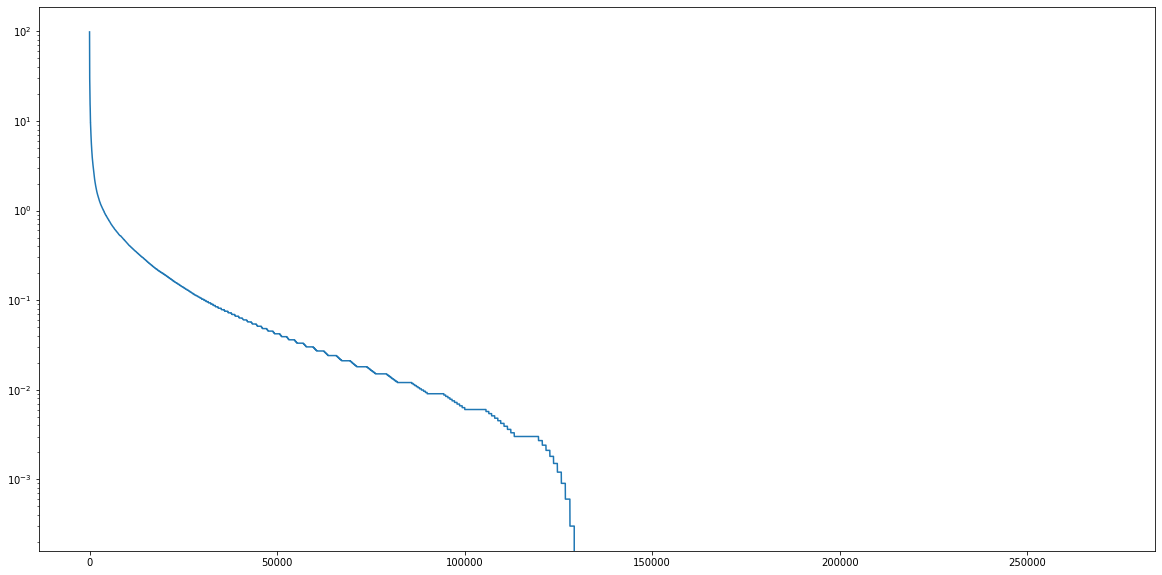

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(s_tr_intr.shape[0]), s_tr_intr.sort_values(ascending=[False]).to_list())
plt.yscale('log')
plt.show()

In [15]:
selector = SelectKBest(score_func=chi2, k=5*10**3)
selector.fit(df_train_intr.drop(columns=['correct', 'group']), df_train_intr['correct'])

SelectKBest(k=5000, score_func=<function chi2 at 0x7f7c9a5071f0>)

In [16]:
cols = list(selector.get_feature_names_out()) + ['correct', 'group']
df_train_intr_s = df_train_intr[cols]
df_test_intr_s = df_test_intr[cols]
df_valid_intr_s = df_valid_intr[cols]

In [17]:
df_train_intr_s.dtypes

name_Action         Sparse[float64, 0]
name_All            Sparse[float64, 0]
name_An             Sparse[float64, 0]
name_Android        Sparse[float64, 0]
name_Application    Sparse[float64, 0]
                           ...        
intr_58641          Sparse[float64, 0]
intr_58655          Sparse[float64, 0]
intr_58750          Sparse[float64, 0]
correct                          int64
group                            int64
Length: 5002, dtype: object

In [18]:
s_tr_intr_s = df_train_intr_s.drop(columns=['group']).sum().div(df_train_intr_s.shape[0]).mul(100)

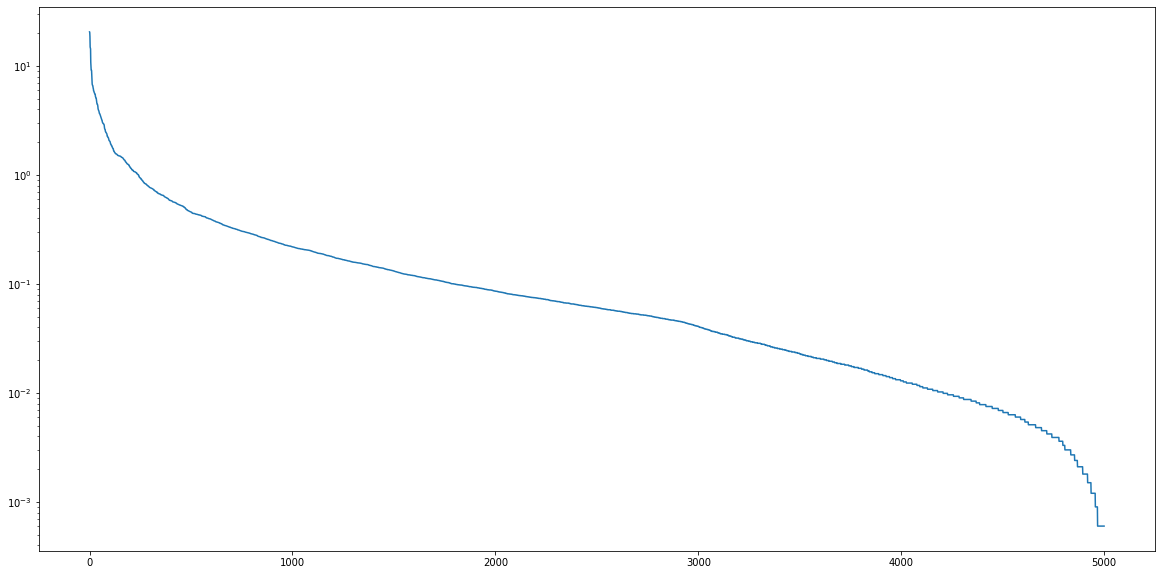

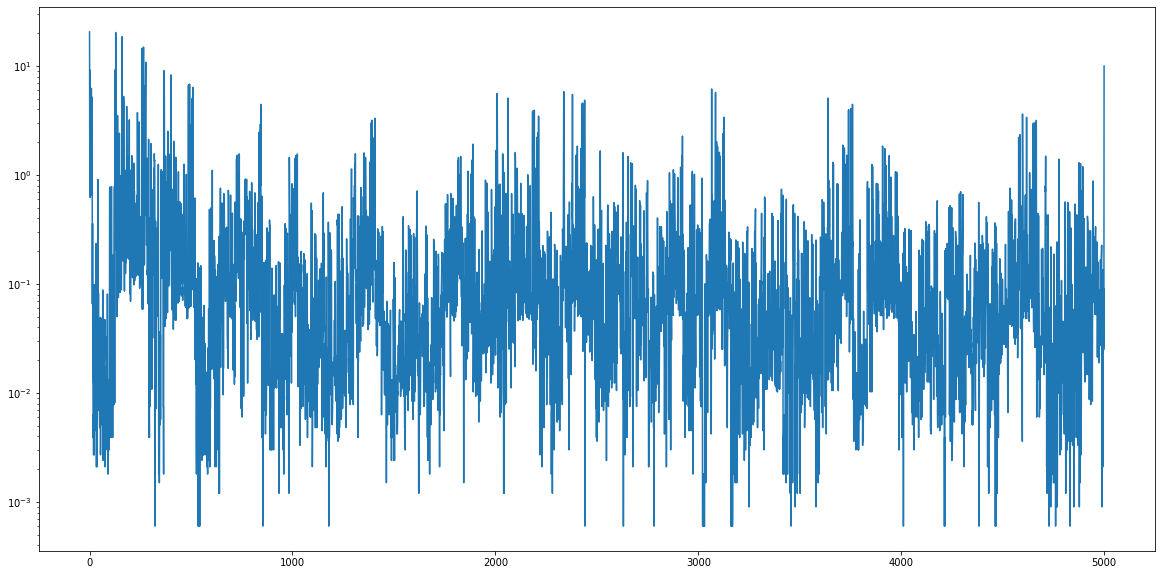

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(s_tr_intr_s.shape[0]), s_tr_intr_s.sort_values(ascending=[False]).to_list())
plt.yscale('log')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(np.arange(s_tr_intr_s.shape[0]), s_tr_intr_s.to_list())
plt.yscale('log')
plt.show()

In [20]:
df_train_intr_s.to_pickle(dataset_folder+'train_ohe401_intr2_2k')
df_test_intr_s.to_pickle(dataset_folder+'test_ohe401_intr2_2k')
df_valid_intr_s.to_pickle(dataset_folder+'valid_ohe401_intr2_2k')